### Dependencies

In [6]:
import tensorflow as tf
import time
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.4 * 2, 4.8 * 2)

### Helpers

In [7]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=1.0 / math.sqrt(np.prod(shape[:-1])))
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def visualize_layer(x, r, c, cmap='binary'):
  fig = plt.figure()
  for n in range(x.shape[-1]):
    a = fig.add_subplot(r, c, n + 1)
    a.set_title(n)
    implot = plt.imshow(x[:, :, n])
    implot.set_cmap(cmap)
    plt.axis('off')

  fig.tight_layout()

### Load data

In [8]:
mnist = input_data.read_data_sets('data/mnist', one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


### Build a graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
x_image = tf.reshape(x, [-1, 28, 28, 1])

# conv -> relu -> max_pool
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# conv -> relu -> max_pool
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# fully connected
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fully connected
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# training
learning_rate = tf.placeholder(tf.float32)
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Train

In [ ]:
lr = 1e-3
steps = 10000
batch_size = 32
log_interval = 200
save_interval = 1000
restore = True
model_path = 'model/mnist_conv.ckpt'
  
with tf.Session() as sess:
  if restore:
    saver.restore(sess, model_path)
  else:
    init = tf.global_variables_initializer()
    sess.run(init)
      
  start_time = time.time()
  
  for i in range(steps):
    batch = mnist.train.next_batch(batch_size)  
    
    sess.run(train_step, 
             feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5, learning_rate: lr})
    
    if i > 0 and i % log_interval == 0:
      validation_accuracy = sess.run(
        accuracy, 
        feed_dict={x: mnist.validation.images, y_: mnist.validation.labels, keep_prob: 1.0}) 
      
      elapsed_time = time.time() - start_time
      seconds_per_iteration = elapsed_time / i
      seconds_left = (steps - i) * seconds_per_iteration
     
      print(('step: %d, validation accuracy: %.4f, learning rate: %.e, time left: %d:%02d' % 
             (i, validation_accuracy, lr, seconds_left // 60, seconds_left % 60)))
      
      if validation_accuracy >= 0.96:
        lr = 1e-4
      if validation_accuracy >= 0.990:
        lr = 1e-5
      if validation_accuracy >= 0.992:
        break
      
    if i > 0 and i % save_interval == 0:
      save_path = saver.save(sess, model_path)
      print('Model saved to file: %s' % save_path)

  print('test accuracy: %g' % sess.run(
    accuracy, 
    feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
  
  # data for visualization
  i_random = 5625
  image = mnist.test.images[i_random].reshape([1, -1])
  label = mnist.test.labels[i_random].reshape([1, -1])
  
  conv1, conv2 = sess.run([h_conv1, h_conv2], 
                          feed_dict={x: image, y_: label, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from model/mnist_conv.ckpt


### Visualize layers

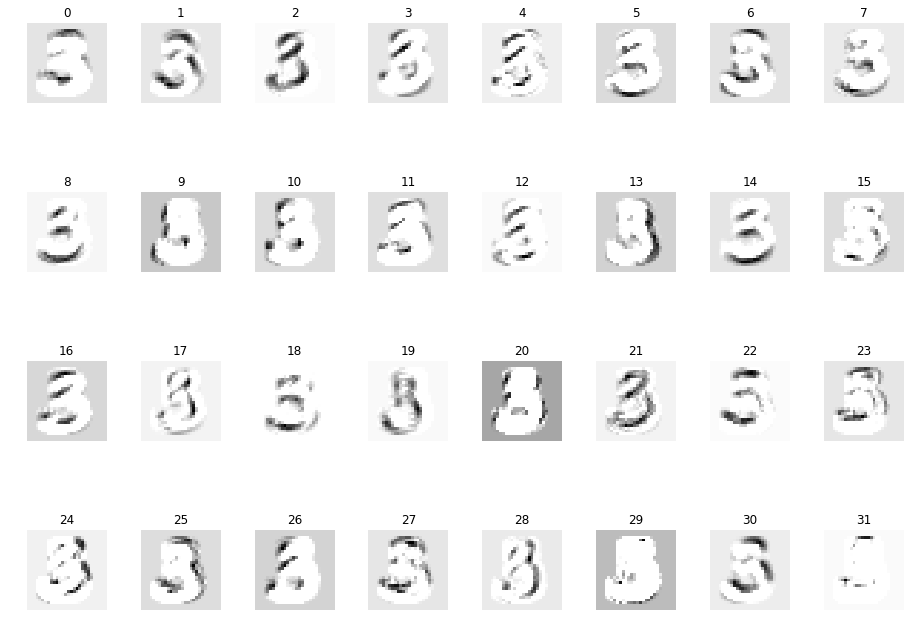

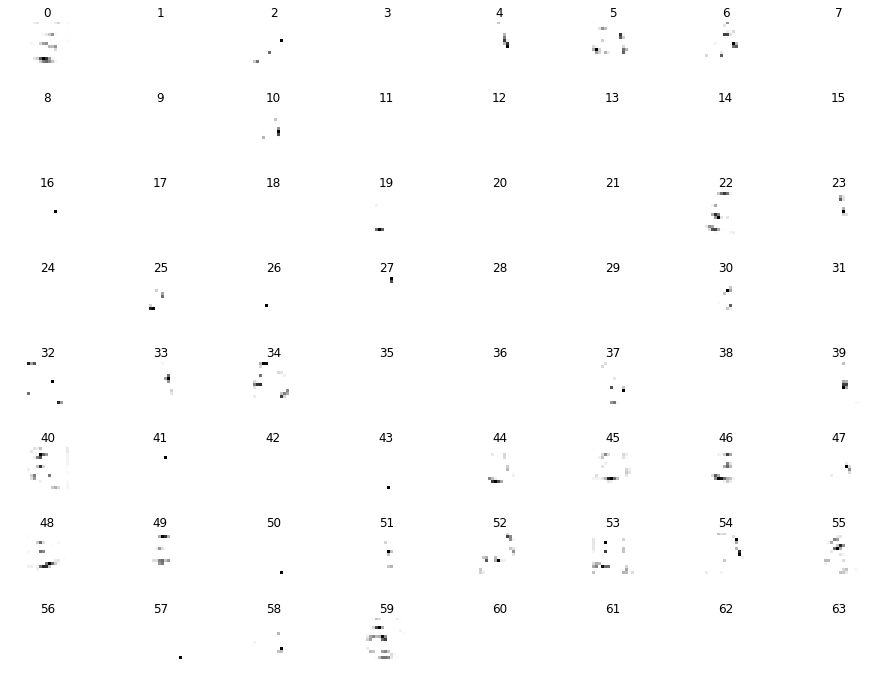

In [19]:
visualize_layer(conv1.reshape([28, 28, 32]), 4, 8)
plt.show()

visualize_layer(conv2.reshape([14, 14, 64]), 8, 8)
plt.show()